# Running ZPIC from Pyhton

ZPIC includes a Python interface allowing you to run simulations directly from a Python environment. This can be done interactively from a console or notebook, or from a Python script.

To run a ZPIC simulation from Python you must do the following:
1. Select the ZPIC version you will be using for the simulation (em2d, em1ds, etc.)
2. Initialize the simulation parameters
3. Run the simulation

In this notebook we illustrate this procedure doing a simple 1D Two-Stream instability simulation.

## Running a simulation

### 1. Selecting the ZPIC version to use

Selecting the ZPIC version to use is done by importing the appropriate module. We will be using the 1D electromangetic spectral code, EM1DS, in this example so we need to import the `em1ds` module.

In [1]:
# Add zpic library to path
import sys
sys.path.append("../../lib")

import em1ds as zpic

### 2. Initializing simulation parameters

As in any ZPIC simulation, we will need to set the particle species parameters, grid, and timestep  to be used for the simulation. For our example we will be using two counter propagating electron species, with:
* Fluid generalized velocity $u_{flx} = \pm 0.4 \, \mathrm{c}$
* Thermal generalized velocity $u_{th} = 10^{-3} \, \mathrm{c}$ in all directions
* 500 particles per cell each

Each of the species will be an instance of the `em1ds.Species` class:

In [2]:
m_q = -1.0                   # mass over charge ratio, in normalized units (1.0 would be a positron)
ppc = 500                    # number of particles per cell
ufl = [0.4,    0.0,  0.0]    # fluid momenta
uth = [0.001,0.001,0.001]    # thermal momenta

# Right going electron species
right = zpic.Species( "right", m_q, ppc, ufl = ufl, uth = uth )

# Left going electron species
ufl[0] = -ufl[0]
left  = zpic.Species( "left", m_q, ppc, ufl = ufl, uth = uth )

Regarding grid parameters and time-step we will be using:
* 120 grid cells 
* A box size of $ 4 \times \pi$ (in normalized units)
* A timestep $\Delta t = 10^{-1}$ (in normalized units)

To complete the initialization we create a `em1ds.Simulation` object specifying these parameters and proving a list of all the species objects in the simulation:

In [3]:
import numpy as np

nx = 120               # Number of grid cells
box = 4 * np.pi        # Simulation box size
dt = 0.1               # Time step

# Simulation object
sim = zpic.Simulation( nx, box, dt, species = [right,left] )

### 3. Running the simulation

We can now run our simulation. The simplest way to run our simulation up to a specified time is to use the `run()` method of the simulation object we just created. To run the simulation up to time $t = 45$ (in normalized units) we do:

In [4]:
sim.run(45.0)


Running simulation up to t = 45 ...
n = 451, t = 45.1
Done.


The simulation will still be active when the command completes, and it is possible to call the `run()` method again to further advance the simulation time. To continue to run the simulation up to time $t = 50$ (in normalized units) we do:

In [5]:
sim.run(50.0)


Running simulation up to t = 50 ...
n = 501, t = 50.1
Done.


This allows us to check the evolution of the various results at different time steps.

## Viewing simulation results

The Python interface allows users to access simulation data directly, without requiring file output. All simulation data is exposed as data members of the `Simulation` object that was used.

### Grid data

We can acces the raw electric field, magnetic field and current density data of a `Simulation` object `sim` through the `sim.emf.E[x|y|z]`, `sim.emf.B[x|y|z]` and `sim.current.J[x|y|z]` properties, respectively. Each of these properties will be a [nx] NumPy float32 array that can be used as usual:

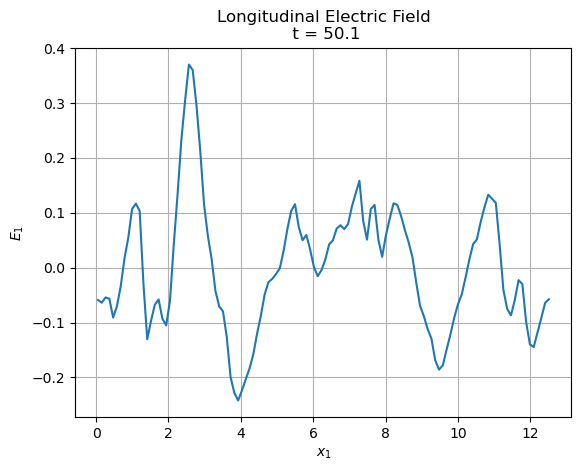

In [6]:
import matplotlib.pyplot as plt

# Plot field values at the center of the cells
xmin = sim.dx/2
xmax = sim.box - sim.dx/2

plt.plot(np.linspace(xmin, xmax, num = sim.nx), sim.emf.Ex )
plt.xlabel("$x_1$")
plt.ylabel("$E_1$")
plt.title("Longitudinal Electric Field\n t = {:g}".format(sim.t))
plt.grid(True)

plt.show()

### Particle data

We can also access raw particle data using the `particles` property of each Species object. This property is a NumPy array of `t_part` structures containing:
* `ix` - the particle cell
* `x` - the particle position inside the cell normalized to the cell size ( 0 <= x < 1 )
* `ux`, `uy`, `uz` - the particle generalized velocity in each direction

We can easily use this data to produce the phasespace plot for this simulation. Note that we had to convert the cell index / position to simulation position:

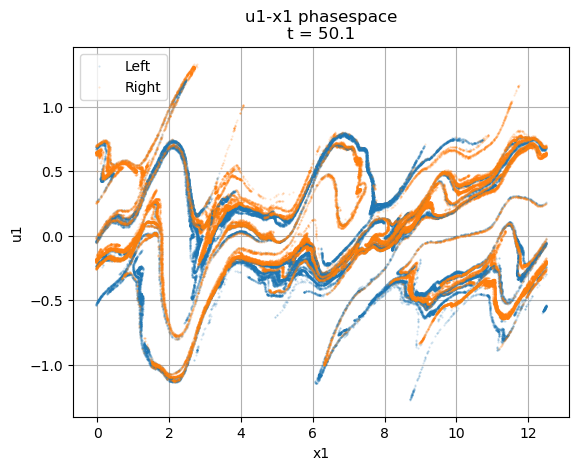

In [7]:
import matplotlib.pyplot as plt

# Simple function to convert particle positions
x = lambda s : (s.particles['ix'] + s.particles['x']) * s.dx 

plt.plot(x(left),  left.particles['ux'],  '.', ms=1,alpha=0.2, label = "Left")
plt.plot(x(right), right.particles['ux'], '.', ms=1,alpha=0.2, label = "Right")
plt.xlabel("x1")
plt.ylabel("u1")
plt.title("u1-x1 phasespace\nt = {:g}".format(sim.t))
plt.legend()
plt.grid(True)
plt.show()

### Charge Density

Besides the raw simulation data, we can also access diagnostic data that needs to be generated, such as the charge density. These diagnostics can be generated on the fly; to get the charge density from a `Species` object we use the `charge()` method:

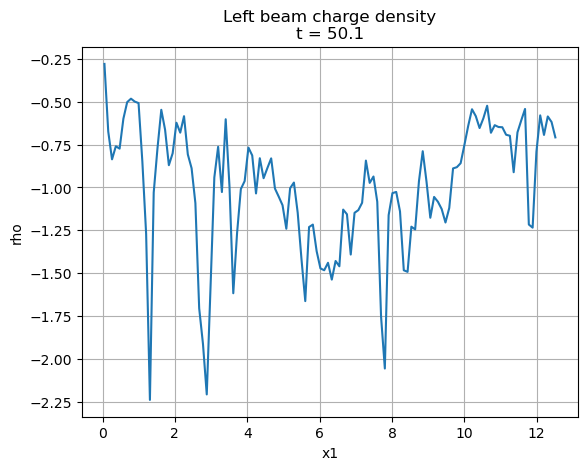

In [8]:
import matplotlib.pyplot as plt

charge = left.charge()

xmin = sim.dx/2
xmax = sim.box - sim.dx/2

plt.plot(np.linspace(xmin, xmax, num = sim.nx), left.charge() ) 
plt.xlabel("x1")
plt.ylabel("rho")
plt.title("Left beam charge density\nt = {:g}".format(sim.t))

plt.grid(True)
plt.show()

### Phasespace Density

Similarily, we can get the phasespace density of a given `Species` object using the `phasespace()` method: 

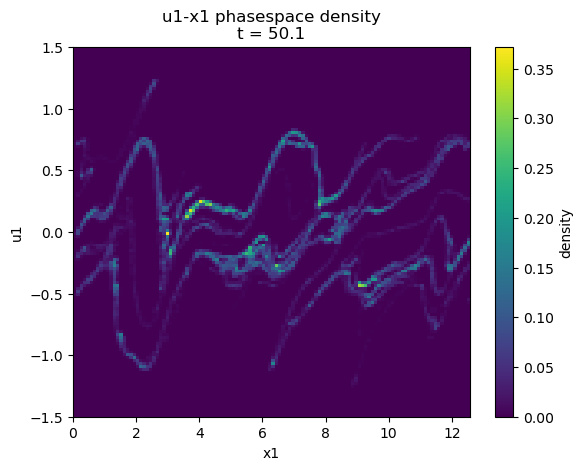

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

nx    = [120,128]
range = [[0,sim.box],[-1.5,1.5]]

pha = np.abs(left.phasespace( ["x1", "u1"], nx, range ))

plt.imshow( pha, interpolation = 'nearest', origin = 'lower',
          extent = ( range[0][0], range[0][1], range[1][0], range[1][1] ),
          aspect = 'auto')

plt.colorbar().set_label('density')
plt.xlabel("x1")
plt.ylabel("u1")
plt.title("u1-x1 phasespace density\nt = {:g}".format(sim.t))

plt.show()

### Saving simulation results

If you your simulation takes a long time to compute, you may want to write diagnostic information to disk for post-processing later. Details on how to do this (and reading back your results) are given in the [Saving Simulation Results](Saving%20results.ipynb) notebook.